# 6.2 AnoGANの作成

- 本ファイルでは、AnoGANのネットワークを実装とAnoGANの学習をします。


# 6.2 学習目標

1.	AnoGANでテスト画像に最も似た画像を生成するノイズzを求める方法を理解する
2.	AnoGANを実装し、手書き数字画像で異常検知が生成できる


# 事前準備
書籍の指示に従い、本章で使用するデータを用意します

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/pytorch_advanced/6_gan_anomaly_detection"

/content/drive/My Drive/Colab Notebooks/pytorch_advanced/6_gan_anomaly_detection


In [3]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [4]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generatorの実装

In [5]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


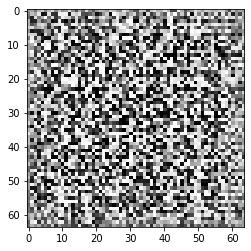

In [6]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [7]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last(out)

        return out, feature


In [8]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)


tensor([[[[0.5066]]]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 8192])


# DataLoaderの作成

In [9]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./../data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./../data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [10]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [11]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [12]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# 学習させる

In [13]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [16]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    
    print("総イテレーション回数:", iteration)

    return G, D


In [17]:
# 学習・検証を実行する
# 8分ほどかかる
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1153 ||Epoch_G_Loss:0.1651
timer:  147.4090 sec.
-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0612 ||Epoch_G_Loss:0.1694
timer:  2.2115 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0065 ||Epoch_G_Loss:0.3762
timer:  2.1271 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.2671 ||Epoch_G_Loss:0.2416
timer:  2.1347 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0225 ||Epoch_G_Loss:0.2479
timer:  2.0899 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0061 ||Epoch_G_Loss:0.3851
timer:  2.0985 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.2078 ||Epoch_G_Loss:0.3625
timer:  2.0680 sec.
-------------
Epoch 7/300
------------

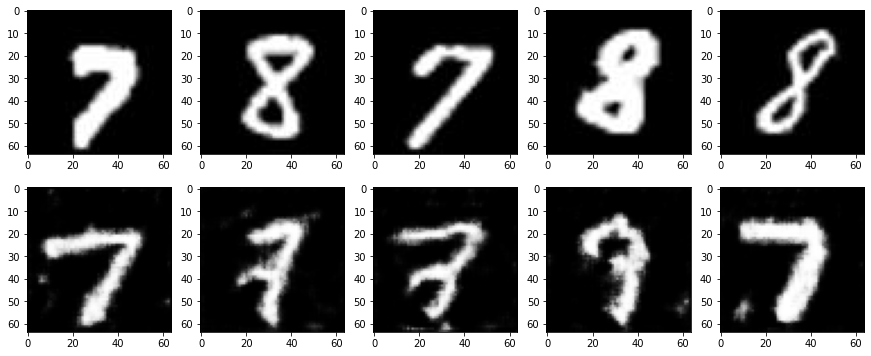

In [18]:
# 生成画像と訓練データを可視化する
# 本セルは何度か実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

# AnoGANの本体

In [19]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量を取り出す
    _, x_feature = D(x)
    _, G_feature = D(fake_img)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


# テスト画像で異常検知する

In [22]:
# テスト用のDataLoaderの作成


def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./../data/test/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./../data/test/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./../data/test/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


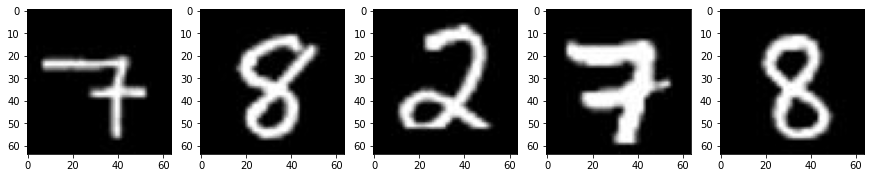

In [23]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  

# 1番目のミニバッチを取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [24]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)

# 異常検知したい画像を生成するための、初期乱数
z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることが可能なように、requires_gradをTrueに設定
z.requires_grad = True

# 変数zを更新できるように、zの最適化関数を求める
z_optimizer = torch.optim.Adam([z], lr=1e-3)


# zを求める
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))


epoch 0 || loss_total:6040 
epoch 1000 || loss_total:3268 
epoch 2000 || loss_total:2615 
epoch 3000 || loss_total:2385 
epoch 4000 || loss_total:2277 
epoch 5000 || loss_total:2236 


total loss： [361. 317. 785. 449. 326.]


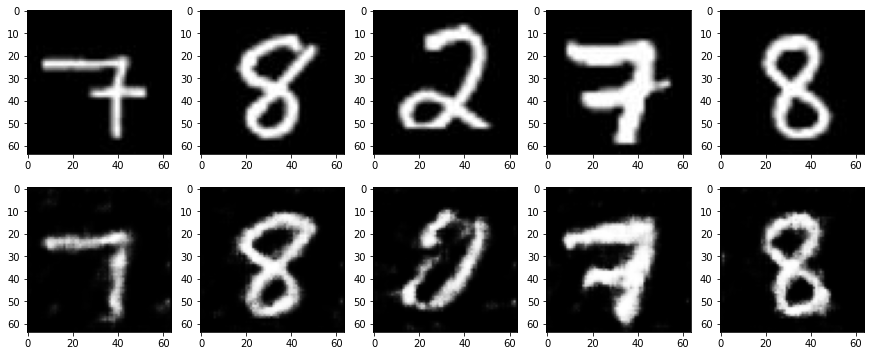

In [25]:
# 画像を生成
G_update.eval()
fake_img = G_update(z)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')


以上